In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:80% !important;}
div.prompt {min-width:70px;}
div#toc-header{margin-top:150px;}
span.toc-item-num{display:none;}
div.CodeMirror {font-family:Consolas}
div.input {font-family:Consolas}
</style>
"""))

# CNN 준비 import / GPU 메모리 정리

In [2]:
import pandas as pd 
import numpy as np
import os
import torch
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, AvgPool2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tqdm import tqdm  # 진행률 표시

In [3]:
# GPU 메모리를 점진적으로 할당하도록 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
torch.cuda.empty_cache()  # GPU 메모리 정리

## 이미지, csv 불러오기 

In [5]:
filepath='../data'

In [6]:
# 데이터 불러오기
X = np.load(os.path.join(filepath,'data.npy'))  # 이미지 데이터 (예: 80,000개)
y_df = pd.read_csv(os.path.join(filepath,'painting.csv'))  # CSV 레이블 데이터

In [7]:
# y 라벨 인코딩 (문자형 → 숫자로 변환)
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y_df["style"])  # 장르를 숫자로 변환

# y 원핫 인코딩 
onehot_encoder = OneHotEncoder(sparse=False)
y_onehot = onehot_encoder.fit_transform(y_labels.reshape(-1, 1))
y_labels[:5],  y_onehot[:5]

C:\Users\ziz0n\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(array([21,  4, 20, 12, 23]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]))

In [8]:
# 장르별 데이터 개수 확인
genre_counts = y_df["style"].value_counts()
genre_ratios = genre_counts / genre_counts.sum()  # 장르별 비율 유지
genre_counts.head(), genre_ratios.head()

(Impressionism         12683
 Realism               10693
 Romanticism            6899
 Expressionism          6646
 Post_Impressionism     6385
 Name: style, dtype: int64,
 Impressionism         0.158225
 Realism               0.133399
 Romanticism           0.086068
 Expressionism         0.082911
 Post_Impressionism    0.079655
 Name: style, dtype: float64)

In [9]:
# 각 장르에서 샘플링할 개수 설정
total_samples = 40000  # 사용할 총 샘플 수
samples_per_genre = (genre_ratios * total_samples).astype(int)

# 최소 10개 이상 유지
min_samples_per_class = 10
samples_per_genre[samples_per_genre < min_samples_per_class] = min_samples_per_class

In [10]:
# 샘플링 수행 (각 장르에서 비율 유지)
selected_indices = []

for genre, sample_count in samples_per_genre.items():
    genre_indices = y_df[y_df["style"] == genre].index.tolist()
    sampled_indices = np.random.choice(genre_indices, sample_count)
    selected_indices.extend(sampled_indices)

X_sample = X[selected_indices]  # 이미지 데이터 샘플링
y_sample = y_onehot[selected_indices]  # 레이블 샘플링

X_sample.shape, y_sample.shape

((39984, 128, 128, 3), (39984, 27))

In [11]:
# train-test 데이터 분할 (stratify=y_sample으로 클래스 균형 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.3, stratify=y_sample, shuffle=True)

X_train.shape, y_train.shape

((27988, 128, 128, 3), (27988, 27))

In [12]:
# 학습 데이터 증강 설정
train_datagen = ImageDataGenerator(
    rotation_range=20,  # 0~20도 회전
    width_shift_range=0.1,  # 가로 이동 (최대 10%)
    height_shift_range=0.1,  # 세로 이동 (최대 10%)
    shear_range=0.2,  # 전단 변형
    zoom_range=0.2,  # 확대/축소 (20%)
    horizontal_flip=True,  # 좌우 반전
    fill_mode="nearest"  # 빈 픽셀을 가장 가까운 값으로 채움
)

# 증강된 학습 데이터 생성
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)

# 검증 데이터는 증강 없이 사용
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow(X_test, y_test, batch_size=64)

## CustomHistory class

In [13]:
class CustomHistory(Callback):  # on_epoch_end()는 각 에포크 종료시 자동 호출
    def __init__(self, times=5):  # 생성자 함수
        self.epoch = 0
        self.times = times
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch%self.times == 0:
            print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_acc:{}'.format(self.epoch, logs.get('loss'), logs.get('accuracy'), logs.get('val_loss'), logs.get('val_accuracy')))

## 1.LeNet

In [14]:
class LeNet:
    @staticmethod
    def build(input_shape=(128, 128, 3), num_classes=len(y_train[0]), activation='relu'):
        model = Sequential([
            Input(shape=input_shape),

            Conv2D(32, kernel_size=(5, 5), activation=activation, kernel_initializer=GlorotNormal(), padding='same'), # GlorotNormal() 가중치 초기화 
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Conv2D(64, kernel_size=(5, 5), activation=activation, kernel_initializer=GlorotNormal(), padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Conv2D(128, kernel_size=(3, 3), activation=activation, kernel_initializer=GlorotNormal(), padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Flatten(), # 평탄화

            Dense(256, activation=activation, kernel_initializer=GlorotNormal()),
            BatchNormalization(),
            Dropout(0.4),

            Dense(128, activation=activation, kernel_initializer=GlorotNormal()),
            BatchNormalization(),
            Dropout(0.4),

            Dense(num_classes, activation='softmax')  # 최종 출력층
        ])
        return model

In [15]:
model = LeNet.build(input_shape=(128, 128, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                        

In [16]:
# 학습설정
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy',
              metrics=['accuracy'])
# 학습시키기
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=30)
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[customHistory,
                                                                                             earlystopping], verbose=1)

Epoch 1/100
875/875 [==============================] - 38s 33ms/step - loss: 3.1134 - accuracy: 0.1749 - val_loss: 2.4939 - val_accuracy: 0.2583
Epoch 2/100
875/875 [==============================] - 28s 32ms/step - loss: 2.5437 - accuracy: 0.2420 - val_loss: 2.4222 - val_accuracy: 0.2577
Epoch 3/100
875/875 [==============================] - 28s 32ms/step - loss: 2.3353 - accuracy: 0.2782 - val_loss: 2.2163 - val_accuracy: 0.3019
Epoch 4/100
875/875 [==============================] - 28s 32ms/step - loss: 2.2225 - accuracy: 0.3029 - val_loss: 2.7547 - val_accuracy: 0.1982
Epoch 5/100
875/875 [==============================] - 28s 32ms/step - loss: 2.0485 - accuracy: 0.3578 - val_loss: 2.2828 - val_accuracy: 0.2969
Epoch 6/100
875/875 [==============================] - 28s 32ms/step - loss: 1.8612 - accuracy: 0.4166 - val_loss: 2.2422 - val_accuracy: 0.3084
Epoch 7/100
875/875 [==============================] - 28s 32ms/step - loss: 1.6361 - accuracy: 0.4879 - val_loss: 2.1503 - val_ac

In [17]:
# 모델평가
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}%'.format(accuracy*100))

375/375 [==============================] - 3s 7ms/step - loss: 3.2664 - accuracy: 0.4682
accuracy : 46.82%


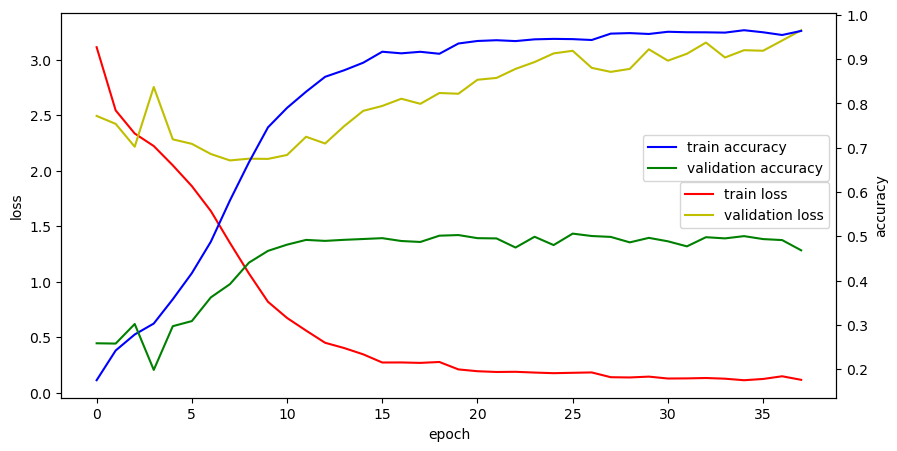

In [18]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [20]:
model.save(os.path.join(filepath,'cnn_lenet_model.h5'))
print("모델 저장 완료")

모델 저장 완료


## 2.AlexNet

In [21]:
class AlexNet:
    @staticmethod
    def build(input_shape=(128,128,3), activation='relu', num_classes=len(y_train[0])):  
        model = Sequential([
            Input(shape=input_shape),

            Conv2D(32, kernel_size=(5,5), strides=(2,2), activation=activation, padding='same'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            BatchNormalization(),

            Conv2D(64, kernel_size=(3,3), activation=activation, padding='same'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            BatchNormalization(),

            Conv2D(128, kernel_size=(3,3), activation=activation, padding='same'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),

            Flatten(),

            Dense(512, activation=activation),
            Dropout(0.3),
            Dense(512, activation=activation),
            Dropout(0.3),

            Dense(num_classes, activation='softmax')
        ])
        return model

In [22]:
model = AlexNet.build(input_shape=(128, 128, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                      

In [23]:
# 학습설정
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy',
              metrics=['accuracy'])
# 학습시키기
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=30)
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[customHistory,
                                                                                             earlystopping], verbose=1)

Epoch 1/100
875/875 [==============================] - 7s 7ms/step - loss: 2.7309 - accuracy: 0.1825 - val_loss: 2.6099 - val_accuracy: 0.2064
Epoch 2/100
875/875 [==============================] - 6s 7ms/step - loss: 2.5262 - accuracy: 0.2172 - val_loss: 2.4766 - val_accuracy: 0.2327
Epoch 3/100
875/875 [==============================] - 6s 7ms/step - loss: 2.3950 - accuracy: 0.2536 - val_loss: 2.3582 - val_accuracy: 0.2417
Epoch 4/100
875/875 [==============================] - 6s 7ms/step - loss: 2.2838 - accuracy: 0.2802 - val_loss: 2.3516 - val_accuracy: 0.2692
Epoch 5/100
875/875 [==============================] - 6s 7ms/step - loss: 2.1617 - accuracy: 0.3167 - val_loss: 2.4074 - val_accuracy: 0.2570
Epoch 6/100
875/875 [==============================] - 6s 7ms/step - loss: 2.0171 - accuracy: 0.3587 - val_loss: 2.1016 - val_accuracy: 0.3441
Epoch 7/100
875/875 [==============================] - 6s 7ms/step - loss: 1.8548 - accuracy: 0.4077 - val_loss: 2.4449 - val_accuracy: 0.2786

875/875 [==============================] - 6s 7ms/step - loss: 0.2188 - accuracy: 0.9332 - val_loss: 2.5977 - val_accuracy: 0.5017


In [24]:
# 모델평가
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}%'.format(accuracy*100))

375/375 [==============================] - 1s 2ms/step - loss: 2.5977 - accuracy: 0.5017
accuracy : 50.17%


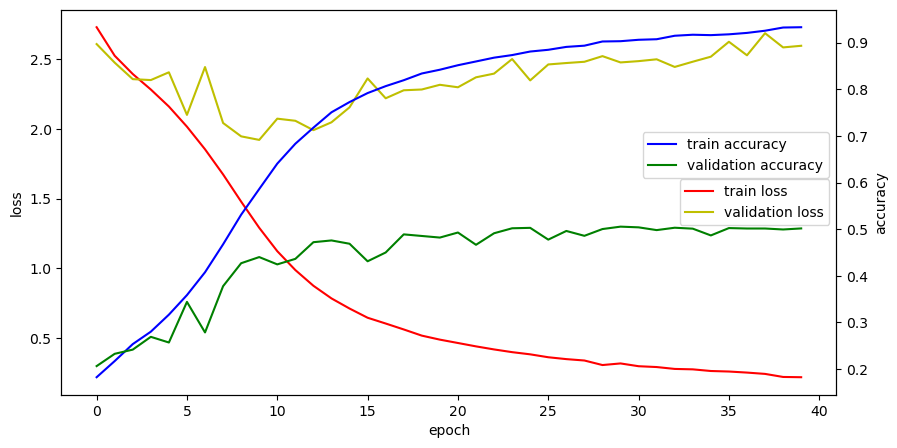

In [25]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [26]:
model.save(os.path.join(filepath,'cnn_alexnet_model.h5'))
print("모델 저장 완료")

모델 저장 완료


## 3. VGGNet

In [27]:
class VGGNet:
    @staticmethod
    def build(input_shape=(128, 128, 3), num_classes=len(y_train[0])):
        model = Sequential()

        # Convolution Block 1
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Convolution Block 2
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Convolution Block 3
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Fully Connected Layer
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

        return model

In [28]:
model = VGGNet.build(input_shape=(128, 128, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_7 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)       

In [30]:
# 학습설정
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy',
              metrics=['accuracy'])
# 학습시키기
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=30)
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[customHistory,
                                                                                             earlystopping], verbose=1)

Epoch 1/100
875/875 [==============================] - 41s 45ms/step - loss: 3.1855 - accuracy: 0.1505 - val_loss: 2.9010 - val_accuracy: 0.1582
Epoch 2/100
875/875 [==============================] - 39s 44ms/step - loss: 2.9134 - accuracy: 0.1567 - val_loss: 2.8712 - val_accuracy: 0.1583
Epoch 3/100
875/875 [==============================] - 39s 44ms/step - loss: 2.8568 - accuracy: 0.1569 - val_loss: 2.7326 - val_accuracy: 0.1583
Epoch 4/100
875/875 [==============================] - 39s 44ms/step - loss: 2.8166 - accuracy: 0.1576 - val_loss: 2.7749 - val_accuracy: 0.1583
Epoch 5/100
875/875 [==============================] - 39s 44ms/step - loss: 2.7909 - accuracy: 0.1572 - val_loss: 2.7915 - val_accuracy: 0.1583
Epoch 6/100
875/875 [==============================] - 39s 44ms/step - loss: 2.7800 - accuracy: 0.1585 - val_loss: 2.7514 - val_accuracy: 0.1583
Epoch 7/100
875/875 [==============================] - 39s 44ms/step - loss: 2.7680 - accuracy: 0.1583 - val_loss: 2.7146 - val_ac

875/875 [==============================] - 38s 43ms/step - loss: 2.4142 - accuracy: 0.2367 - val_loss: 2.4599 - val_accuracy: 0.2411
Epoch 40/100
875/875 [==============================] - 38s 43ms/step - loss: 2.3909 - accuracy: 0.2435 - val_loss: 2.4696 - val_accuracy: 0.2505
Epoch 41/100
875/875 [==============================] - 38s 43ms/step - loss: 2.3658 - accuracy: 0.2447 - val_loss: 2.6265 - val_accuracy: 0.2599
Epoch 42/100
875/875 [==============================] - 38s 43ms/step - loss: 2.3531 - accuracy: 0.2525 - val_loss: 2.4834 - val_accuracy: 0.2643
Epoch 43/100
875/875 [==============================] - 38s 43ms/step - loss: 2.3252 - accuracy: 0.2598 - val_loss: 2.5605 - val_accuracy: 0.2747
Epoch 44/100
875/875 [==============================] - 38s 43ms/step - loss: 2.3156 - accuracy: 0.2606 - val_loss: 2.5551 - val_accuracy: 0.2746
Epoch 45/100
875/875 [==============================] - 38s 43ms/step - loss: 2.2916 - accuracy: 0.2678 - val_loss: 2.4297 - val_accuracy

In [31]:
# 모델평가
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}%'.format(accuracy*100))

375/375 [==============================] - 4s 10ms/step - loss: 2.6492 - accuracy: 0.3413
accuracy : 34.13%


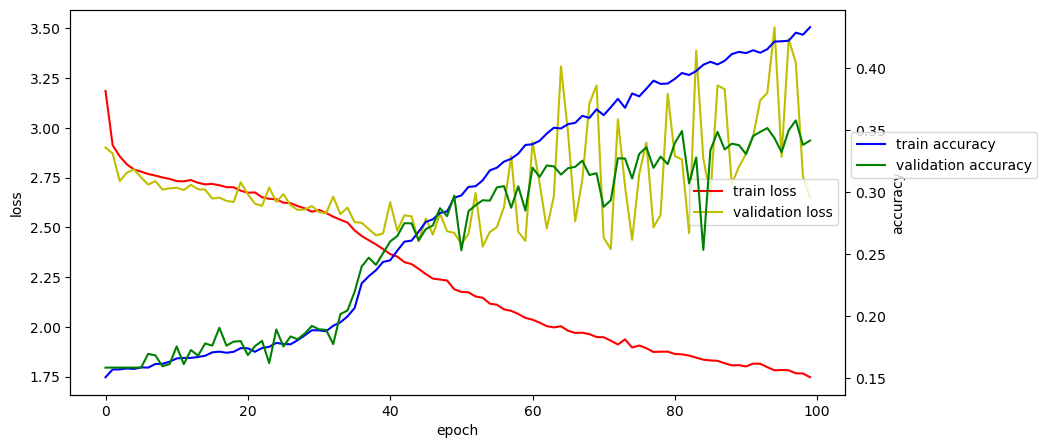

In [32]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [33]:
model.save(os.path.join(filepath,'cnn_vggnet_model.h5'))
print("모델 저장 완료")

모델 저장 완료
